In [1]:
import GPy
import pandas as pd
import zipfile
import urllib.request
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#from torch.optim import Optimizer
from sklearn.model_selection import KFold

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

In [2]:
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())

'GeForce GTX 980 Ti'

In [3]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [4]:
def log_gaussian_loss(output, target, sigma, no_dim, sum_reduce=True):
    exponent = -0.5*(target - output)**2/sigma**2
    log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
    
    if sum_reduce:
        return -(log_coeff + exponent).sum()
    else:
        return -(log_coeff + exponent)


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [5]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (2/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.01, 0.01))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-3, -3))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.01, 0.01))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-4, -3))
        
    def forward(self, x, sample = True):
        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [6]:
class BBP_Heteroscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [7]:
class BBP_Heteroscedastic_Model_Wrapper:
    def __init__(self, network, learn_rate, batch_size, no_batches):
        
        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = network
        self.network.cuda()
        
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr = self.learn_rate)
        self.loss_func = log_gaussian_loss
    
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)

            # calculate fit loss based on mean and standard deviation of output
            fit_loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)
            fit_loss_total = fit_loss_total + fit_loss
        
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total
    
    def get_loss_and_rmse(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=True)
        
        means, stds = [], []
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            means.append(output[:, :1, None])
            stds.append(output[:, 1:, None].exp())
            
        means, stds = torch.cat(means, 2), torch.cat(stds, 2)
        mean = means.mean(dim=2)
        std = (means.var(dim=2) + stds.mean(dim=2)**2)**0.5
            
        # calculate fit loss based on mean and standard deviation of output
        logliks = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1, sum_reduce=False)
        rmse = float((((mean - y)**2).mean()**0.5).cpu().data)

        return logliks, rmse

In [8]:
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*(x + 2)**2*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_mean = y[75:325].mean()
y_std = y[75:325].var()**0.5
y_train = (y[75:325] - y_mean)/y_std

In [9]:
def true_f(x):
    return np.sin(12.0 * x) + 0.66 * np.cos(25.0 * x) + 3.0


def get_data(train_size=100, test_size=100):
    n = train_size + test_size

    np.random.seed(42)

    #X = np.linspace(-2.0, 2.0, num=n)
    X = np.random.uniform(-1.0, 1.0, n)
    Y = true_f(X) + np.random.normal(0, 0.1, n)

    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

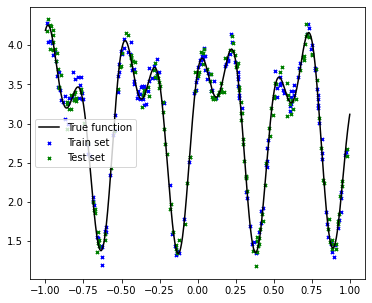

In [10]:
true_x = np.linspace(-1.0, 1.0, 1000)
true_y = true_f(true_x)

X_train, y_train, X_test, y_test = get_data(200, 200)

plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_train, y_train, s=10, marker='x', color='blue', label='Train set')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.legend()

plt.show()

In [11]:
x_train = X_train

num_epochs, batch_size, nb_train = 2000, len(x_train), len(x_train)

net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model(input_dim=1, output_dim=1, num_units=200),
                                        learn_rate=1e-2, batch_size=batch_size, no_batches=1)

fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 10)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %7.3f, KL loss = %8.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i]))

        samples = []
        #for i in range(100):
        #    preds = net.network.forward(torch.linspace(-3, 3, 200).cuda())[0]
        #    samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 2000, Fit loss = 246127.156, KL loss = 2121.888
Epoch:   101/ 2000, Fit loss = 50474.172, KL loss = 2142.326
Epoch:   201/ 2000, Fit loss = 50121.395, KL loss = 2192.427
Epoch:   301/ 2000, Fit loss = 49791.473, KL loss = 2232.631
Epoch:   401/ 2000, Fit loss = 49965.273, KL loss = 2270.877
Epoch:   501/ 2000, Fit loss = 49933.609, KL loss = 2304.081
Epoch:   601/ 2000, Fit loss = 49980.824, KL loss = 2332.519
Epoch:   701/ 2000, Fit loss = 49795.512, KL loss = 2359.329
Epoch:   801/ 2000, Fit loss = 49890.012, KL loss = 2380.858
Epoch:   901/ 2000, Fit loss = 49992.500, KL loss = 2397.421
Epoch:  1001/ 2000, Fit loss = 49763.953, KL loss = 2412.586
Epoch:  1101/ 2000, Fit loss = 49800.371, KL loss = 2423.369
Epoch:  1201/ 2000, Fit loss = 49739.520, KL loss = 2432.726
Epoch:  1301/ 2000, Fit loss = 49724.188, KL loss = 2438.643
Epoch:  1401/ 2000, Fit loss = 49680.262, KL loss = 2443.183
Epoch:  1501/ 2000, Fit loss = 49708.406, KL loss = 2444.164
Epoch:  1601/ 2000, Fit

In [15]:
n_samples = 100

X_test_cuda = torch.from_numpy(X_test.reshape((-1, 1))).float().cuda()

samples_m = np.zeros((n_samples, X_test.shape[0]))
samples_s = np.zeros_like(samples_m)
for i in range(n_samples):
    preds = best_net.forward(X_test_cuda)[0]
    np_m = preds[:, 0].cpu().data.numpy()
    np_s = preds[:, 1].exp().cpu().data.numpy()
    samples_m[i, :] = np_m
    samples_s[i, :] = np_s

y_pred = samples_m.mean(axis=0)
y_err = 2 * samples_s.mean(axis=0)

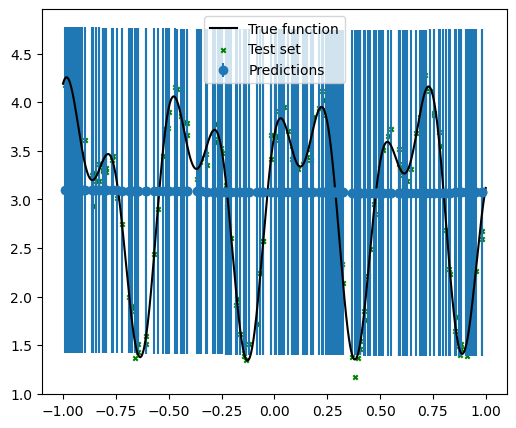

In [16]:
plt.figure(figsize = (6, 5))
plt.style.use('default')

plt.plot(true_x, true_y, color='black', label='True function')
plt.scatter(X_test, y_test, s=10, marker='x', color='green', label='Test set')

plt.errorbar(X_test, y_pred, yerr=y_err, fmt='o', label='Predictions')

plt.legend()

plt.show()

NameError: name 'files' is not defined

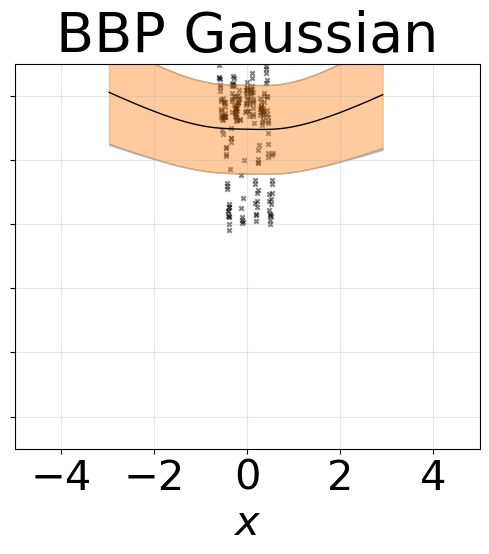

In [14]:
samples, noises = [], []
for i in range(100):
    preds = best_net.forward(torch.linspace(-5, 5, 200).cuda())[0]
    samples.append(preds[:, 0].cpu().data.numpy()* y_std + y_mean)
    noises.append(preds[:, 1].exp().cpu().data.numpy()* y_std)

samples = np.array(samples)
noises = np.array(noises)
means = samples.mean(axis = 0)

aleatoric = (noises**2).mean(axis = 0)**0.5
epistemic = samples.var(axis = 0)**0.5
aleatoric = np.minimum(aleatoric, 10e3)
epistemic = np.minimum(epistemic, 10e3)

total_unc = (aleatoric**2 + epistemic**2)**0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

x_mean, x_std = x_train.mean(), x_train.var()**0.5
plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train * x_std + x_mean, y_train * y_std + y_mean, s = 10, marker = 'x', color = 'black', alpha = 0.5)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = 'Epistemic + Aleatoric')
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
plt.fill_between(np.linspace(-5, 5, 200)* x_std + x_mean, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = 'Aleatoric')
plt.plot(np.linspace(-5, 5, 200)* x_std + x_mean, means, color = 'black', linewidth = 1)
plt.xlim([-5, 5])
plt.ylim([-5, 7])
plt.xlabel('$x$', fontsize=30)
plt.title('BBP Gaussian', fontsize=40)
plt.tick_params(labelsize=30)
plt.xticks(np.arange(-4, 5, 2))
plt.yticks(np.arange(-4, 7, 2))
plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('bbp_hetero.pdf', bbox_inches = 'tight')

files.download("bbp_hetero.pdf")

plt.show()

# UCI dataset fitting

In [ ]:
class BBP_Heteroscedastic_Model_UCI(nn.Module):
    def __init__(self, input_dim, output_dim, num_units):
        super(BBP_Heteroscedastic_Model_UCI, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer
        self.layer1 = BayesLinear_Normalq(input_dim, num_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(num_units, num_units, gaussian(0, 1))
        self.layer3 = BayesLinear_Normalq(num_units, 2*output_dim, gaussian(0, 1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
    
    def forward(self, x):
        
        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)
        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

def train_BBP(data, n_splits, num_epochs, num_units, learn_rate, log_every):
    kf = KFold(n_splits=n_splits)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    for i, idx in enumerate(kf.split(data)):
        print('FOLD %d:' % i)

        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]

        x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
        y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

        x_train = (x_train - x_means)/x_stds
        y_train = (y_train - y_means)/y_stds

        x_test = (x_test - x_means)/x_stds
        y_test = (y_test - y_means)/y_stds

        batch_size, nb_train = len(x_train), len(x_train)

        net = BBP_Heteroscedastic_Model_Wrapper(network=BBP_Heteroscedastic_Model_UCI(input_dim=x_test.shape[-1], output_dim=1, num_units=num_units),
                                                learn_rate=1e-2, batch_size=batch_size, no_batches=1)

        fit_loss_train = np.zeros(num_epochs)
        KL_loss_train = np.zeros(num_epochs)
        total_loss = np.zeros(num_epochs)

        best_net, best_loss = None, float('inf')

        for i in range(num_epochs):

            fit_loss, KL_loss = net.fit(x_train, y_train, no_samples = 20)
            fit_loss_train[i] += fit_loss.cpu().data.numpy()
            KL_loss_train[i] += KL_loss.cpu().data.numpy()

            total_loss[i] = fit_loss_train[i] + KL_loss_train[i]

            if fit_loss < best_loss:
                best_loss = fit_loss
                best_net = copy.deepcopy(net.network)

            if i % log_every == 0 or i == num_epochs - 1:

                train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
                test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

                print('Epoch: %s/%d, Train loglik = %.3f, Test loglik = %.3f, Train RMSE = %.3f, Test RMSE = %.3f' %\
                      (str(i+1).zfill(3), num_epochs, -train_losses.mean() - np.log(y_stds)[0],
                       -test_losses.mean() - np.log(y_stds)[0], y_stds*train_rmse, y_stds*test_rmse))


        train_losses, train_rmse = net.get_loss_and_rmse(x_train, y_train, 20)
        test_losses, test_rmse = net.get_loss_and_rmse(x_test, y_test, 20)

        train_logliks.append((train_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))
        test_logliks.append((test_losses.cpu().data.numpy().mean() + np.log(y_stds)[0]))

        train_rmses.append(y_stds*train_rmse)
        test_rmses.append(y_stds*test_rmse)

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var()**0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var()**0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var()**0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var()**0.5))

    return best_net

# Housing dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data" --no-check-certificate 
data = pd.read_csv('housing.data', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

# Concrete compressive dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls" --no-check-certificate
data = pd.read_excel('Concrete_Data.xls', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

# Energy efficiency dataset

In [ ]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx" --no-check-certificate
data = pd.read_excel('ENB2012_data.xlsx', header=0, delimiter="\s+").values
data = data[np.random.permutation(np.arange(len(data)))]

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

# Power dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip" --no-check-certificate 
zipped = zipfile.ZipFile("CCPP.zip")
data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
np.random.shuffle(data)

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

# Red wine dataset

In [ ]:
np.random.seed(0)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv" --no-check-certificate 
data = pd.read_csv('winequality-red.csv', header=1, delimiter=';').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)

# Yacht dataset

In [ ]:
np.random.seed(0)
!wget "http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data" --no-check-certificate 
data = pd.read_csv('yacht_hydrodynamics.data', header=1, delimiter='\s+').values
data = data[np.random.permutation(np.arange(len(data)))]
data.shape

In [ ]:
model = train_BBP(data, n_splits=10, num_epochs=100, num_units=100, learn_rate=1e-2, log_every=10)